**光谱分析**

- @Date: 2024-01-15
- @Author: Rui Zhu 
- @Follow: https://specutils.readthedocs.io/en/stable/analysis.html

In [1]:
import numpy as np
from astropy import units as u
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models
from specutils import Spectrum1D, SpectralRegion

np.random.seed(2024)

创建试验光谱

Text(0, 0.5, 'Jy')

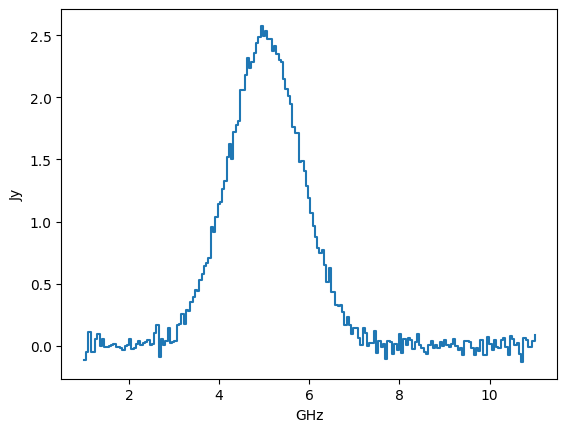

In [2]:
spectral_axis = np.linspace(11., 1., 200) * u.GHz
spectral_model = models.Gaussian1D(amplitude=5*(2*np.pi*0.8**2)**-0.5*u.Jy, mean=5*u.GHz, stddev=0.8*u.GHz)
flux = spectral_model(spectral_axis)
flux += np.random.normal(0., 0.05, spectral_axis.shape) * u.Jy
uncertainty = StdDevUncertainty(0.2*np.ones(flux.shape)*u.Jy)

noisy_gaussian = Spectrum1D(spectral_axis=spectral_axis, flux=flux, uncertainty=uncertainty)

import matplotlib.pyplot as plt 
plt.step(noisy_gaussian.spectral_axis, noisy_gaussian.flux)
plt.xlabel(noisy_gaussian.spectral_axis.unit)
plt.ylabel(noisy_gaussian.flux.unit)

---
# SNR
* 计算光谱的信噪比
* 既可以计算整个光谱的信噪比，也可以计算局部光谱的信噪比

## 基于uncertainty的SNR估计

In [3]:
from specutils.analysis import snr
snr(noisy_gaussian)

<Quantity 2.50180103>

In [4]:
snr(noisy_gaussian, SpectralRegion(6*u.GHz, 4*u.GHz)) 

<Quantity 9.826123>

## 无需uncertainty的SNR估计

In [5]:
from specutils.analysis import snr_derived
snr_derived(noisy_gaussian) 

<Quantity 0.96653353>

In [6]:
snr_derived(noisy_gaussian, SpectralRegion(6*u.GHz, 4*u.GHz))

<Quantity 37.76511439>

---
# 谱线flux与equivalent width估计
* 使用光谱拟合估计线强是更彻底的方法
* 而这种直接估计流量的方法更适合快速估计和光谱不好拟合的情况

## 使用line_flux函数估计谱线强度
* 注意: 必须提前扣除连续谱

In [11]:
from specutils.analysis import line_flux
flux = line_flux(noisy_gaussian, SpectralRegion(3*u.GHz, 7*u.GHz))
flux.to(u.erg * u.cm**-2 * u.s**-1)

<Quantity 4.96057352e-14 erg / (s cm2)>

* 同时测量了不确定度

In [15]:
flux = line_flux(noisy_gaussian)
flux.uncertainty.to(u.erg * u.cm**-2 * u.s**-1)

<Quantity 1.42132016e-15 erg / (s cm2)>

In [17]:
type(noisy_gaussian)

specutils.spectra.spectrum1d.Spectrum1D

## 使用equivalent_width函数估计等值宽度
* 必须包含一个连续谱

In [18]:
from specutils.analysis import equivalent_width
noisy_gaussian_with_continuum = noisy_gaussian + 1*u.Jy  # add a continuums
equivalent_width(noisy_gaussian_with_continuum)

<Quantity -5.02874578 GHz>

In [19]:
equivalent_width(noisy_gaussian_with_continuum, regions=SpectralRegion(7*u.GHz, 3*u.GHz))  

<Quantity -4.96057352 GHz>

---
# 线心
* 需扣除连续谱

In [23]:
from specutils.analysis import centroid
lc = centroid(noisy_gaussian, SpectralRegion(7*u.GHz, 3*u.GHz))
lc

<Quantity 4.9933813 GHz>

In [25]:
lc.uncertainty  # uncertainty in the line centroid

<Quantity 0.02102823 GHz>

In [26]:
lc.uncertainty_type

'stddev'

---
# Moment

In [27]:
from specutils.analysis import moment
moment(noisy_gaussian, SpectralRegion(7*u.GHz, 3*u.GHz)) 

<Quantity 98.71541307 Jy>

In [28]:
moment(noisy_gaussian, SpectralRegion(7*u.GHz, 3*u.GHz), order=1) 

<Quantity 4.9933813 GHz>

In [29]:
moment(noisy_gaussian, SpectralRegion(7*u.GHz, 3*u.GHz), order=2)

<Quantity 0.59440565 GHz2>

---
# [Line Widths](https://specutils.readthedocs.io/en/stable/analysis.html#line-widths)